In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate, optimize, special, interpolate
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV as cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

import powerlaw


plt.rcParams['font.family'] ='sans-serif'#使用するフォント
plt.rcParams['xtick.direction'] = 'in'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0#x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0#y軸主目盛り線の線幅
plt.rcParams['font.size'] = 8 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 1.0# 軸の線幅edge linewidth。囲みの太さ

In [2]:
df = pd.read_pickle('../data/df.pickle')

df_lockdown = df[(df["started_at"] >= "2020-03-21") & (df["started_at"] < "2020-06-01")].dropna()
df_20200601_20201116 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] < "2020-11-17")].dropna()
df_20201117_20201216 = df[(df["started_at"] >= "2020-11-17") & (df["started_at"] < "2020-12-17")].dropna()
df_20201217_20201231 = df[(df["started_at"] >= "2020-12-17") & (df["started_at"] < "2021-01-01")].dropna()
df_2021 = df[(df["started_at"] >= "2021-01-01") & (df["started_at"] < "2022-01-01")].dropna()
df_2022 = df[(df["started_at"] >= "2022-01-01") & (df["started_at"] < "2023-01-01")].dropna()
df_2023 = df[(df["started_at"] >= "2023-01-01") & (df["started_at"] < "2023-10-01")].dropna()
df_2020 = df[(df["started_at"] >= "2020-01-01") & (df["started_at"] < "2021-01-01")].dropna()

In [3]:
def getNetworkAnalysis(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df = df.sort_values(by='start_station_name')

    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []
    distance_list = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # ユニークな駅のリストを取得
        # values.ravel('K')で多次元配列を1次元配列に変換
        unique_stations = pd.unique(df_tmp[['start_station_name', 'end_station_name']].values.ravel('K'))

        # node_listにノード数を追加
        node_list.append(len(unique_stations))

        # edge_listにエッジ数を追加
        df_tmp = df_tmp.drop_duplicates(subset=['start_station_name', 'end_station_name'])
        edge_list.append(len(df_tmp))

        # distance_listに平均距離を追加
        distance_list.append(df_tmp['distance'].mean())

        current_timestamp = next_timestamp

    return node_list, edge_list, timestamp, distance_list

In [4]:
def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i), limit=5000)[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N 

In [5]:
node_lockdown, edge_lockdown, timestamp_lockdown, distance_lockdown = getNetworkAnalysis(df_lockdown)
node_after_lockdown, edge_after_lockdown, timestamp_after_lockdown, distance_after_lockdown = getNetworkAnalysis(df_20200601_20201116)
node_stayhome, edge_stayhome, timestamp_stayhome, distance_stayhome = getNetworkAnalysis(df_20201117_20201216)
node_after_stayhome, edge_after_stayhome, timestamp_after_stayhome, distance_after_stayhome = getNetworkAnalysis(df_20201217_20201231)
node_2021, edge_2021, timestamp_2021, distance_2021 = getNetworkAnalysis(df_2021)
node_2022, edge_2022, timestamp_2022, distance_2022 = getNetworkAnalysis(df_2022)
node_2023, edge_2023, timestamp_2023, distance_2023 = getNetworkAnalysis(df_2023)
node_2020, edge_2020, timestamp_2020, distance_2020 = getNetworkAnalysis(df_2020)

In [6]:
alpha_lockdown, beta_lockdown = 0.086, 1.257
alpha_after_lockdown, beta_after_lockdown = 0.085, 5.735
alpha_stayhome, beta_stayhome = 0.085, 1.626
alpha_after_stayhome, beta_after_stayhome = 0.094, 3.621
alpha_2020, beta_2020 = 0.075, 0.795 
alpha_2021, beta_2021 = 0.087, 2.238
alpha_2022, beta_2022 = 0.118, 8.603
alpha_2023, beta_2023 = 0.119, 7.9

Np = 1652

In [8]:
print("Expected value at lockdown: ", alpha_lockdown/(alpha_lockdown+beta_lockdown))
print("Expected value after lockdown: ", alpha_after_lockdown/(alpha_after_lockdown+beta_after_lockdown))
print("Expected value at stayhome: ", alpha_stayhome/(alpha_stayhome+beta_stayhome))
print("Expected value after stayhome: ", alpha_after_stayhome/(alpha_after_stayhome+beta_after_stayhome))
print("Expected value at 2020: ", alpha_2020/(alpha_2020+beta_2020))
print("Expected value at 2021: ", alpha_2021/(alpha_2021+beta_2021))
print("Expected value at 2022: ", alpha_2022/(alpha_2022+beta_2022))
print("Expected value at 2023: ", alpha_2023/(alpha_2023+beta_2023))

lockdown_bar = alpha_lockdown/(alpha_lockdown+beta_lockdown)
after_lockdown_bar = alpha_after_lockdown/(alpha_after_lockdown+beta_after_lockdown)
stayhome_bar = alpha_stayhome/(alpha_stayhome+beta_stayhome)
after_stayhome_bar = alpha_after_stayhome/(alpha_after_stayhome+beta_after_stayhome)
ex_2020_bar = alpha_2020/(alpha_2020+beta_2020)
ex_2021_bar = alpha_2021/(alpha_2021+beta_2021)
ex_2022_bar = alpha_2022/(alpha_2022+beta_2022)
ex_2023_bar = alpha_2023/(alpha_2023+beta_2023)


Expected value at lockdown:  0.06403574087862993
Expected value after lockdown:  0.014604810996563574
Expected value at stayhome:  0.04967855055523087
Expected value after stayhome:  0.025302826379542398
Expected value at 2020:  0.08620689655172413
Expected value at 2021:  0.03741935483870967
Expected value at 2022:  0.013530558422199288
Expected value at 2023:  0.01483975558049632


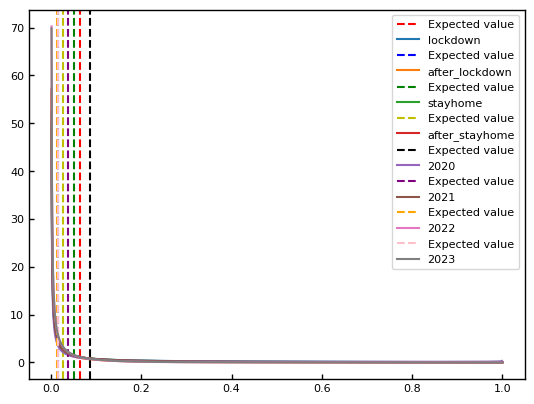

In [16]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
## 計算
x = np.linspace(0, 1, 1000) #x軸
y = beta.pdf(x, alpha_lockdown, beta_lockdown)      #y軸
# 期待値を線で引く
plt.axvline(x=lockdown_bar, color='r', linestyle='--', label="Expected value")
## グラフ
plt.plot(x, y, label="lockdown")

y = beta.pdf(x, alpha_after_lockdown, beta_after_lockdown)      #y軸
# 期待値を線で引く
plt.axvline(x=after_lockdown_bar, color='b', linestyle='--', label="Expected value")
## グラフ
plt.plot(x, y, label="after_lockdown")

y = beta.pdf(x, alpha_stayhome, beta_stayhome)      #y軸
# 期待値を線で引く
plt.axvline(x=stayhome_bar, color='g', linestyle='--', label="Expected value")
## グラフ
plt.plot(x, y, label="stayhome")

y = beta.pdf(x, alpha_after_stayhome, beta_after_stayhome)      #y軸
# 期待値を線で引く
plt.axvline(x=after_stayhome_bar, color='y', linestyle='--', label="Expected value")
## グラフ
plt.plot(x, y, label="after_stayhome")

y = beta.pdf(x, alpha_2020, beta_2020)      #y軸
# 期待値を線で引く
plt.axvline(x=ex_2020_bar, color='black', linestyle='--', label="Expected value")
## グラフ
plt.plot(x, y, label="2020")

y = beta.pdf(x, alpha_2021, beta_2021)      #y軸
# 期待値を線で引く
plt.axvline(x=ex_2021_bar, color='purple', linestyle='--', label="Expected value")
## グラフ
plt.plot(x, y, label="2021")

y = beta.pdf(x, alpha_2022, beta_2022)      #y軸
# 期待値を線で引く
plt.axvline(x=ex_2022_bar, color='orange', linestyle='--', label="Expected value")
## グラフ
plt.plot(x, y, label="2022")

y = beta.pdf(x, alpha_2023, beta_2023)      #y軸
# 期待値を線で引く
plt.axvline(x=ex_2023_bar, color='pink', linestyle='--', label="Expected value")

## グラフ
plt.plot(x, y, label="2023")

plt.legend()
plt.show()

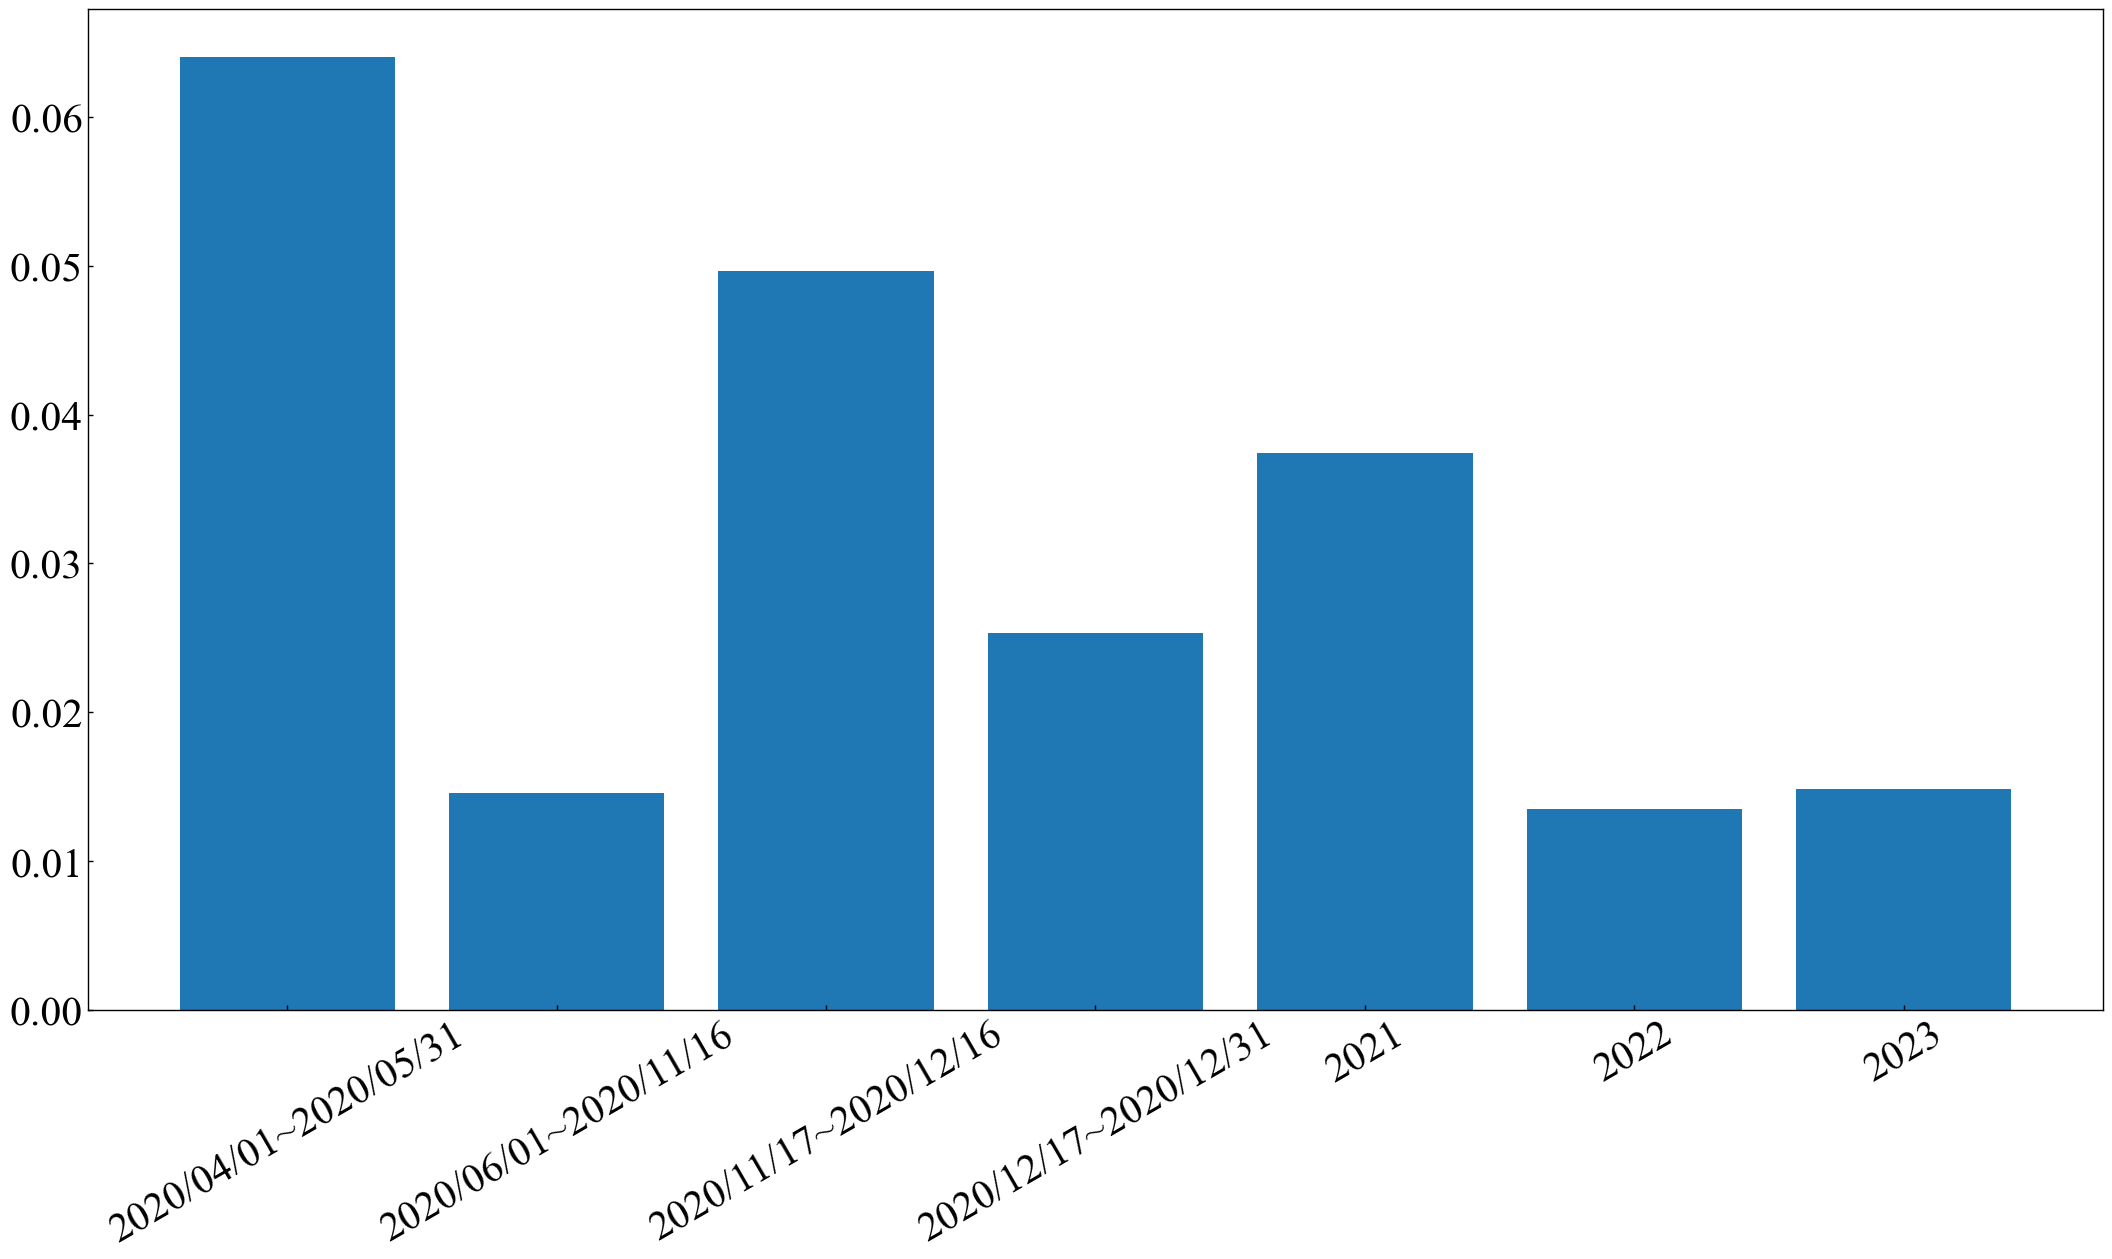

In [36]:
# 期待値を時系列でプロットする
labels = ["2020/04/01~2020/05/31", "2020/06/01~2020/11/16", "2020/11/17~2020/12/16", "2020/12/17~2020/12/31", "2021", "2022", "2023"]
bars = [lockdown_bar, after_lockdown_bar, stayhome_bar, after_stayhome_bar, ex_2021_bar, ex_2022_bar, ex_2023_bar]

plt.figure(figsize=(26, 13))
# 日本語フォントを設定
plt.rcParams['font.family'] = 'Times New Roman'

plt.bar(labels, bars)

#plt.ylabel("期待値")
plt.xticks(rotation=30)
plt.tick_params(labelsize=30)

# plt.legend()
plt.show()